In [121]:
from datetime import datetime, timedelta
from data import *
from window import *
import matplotlib.pyplot as plt
import numpy as np

ticker = 'PANW'
start_date = (datetime.today() - timedelta(days=30)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')
stock_data = fetch_stock_prices(ticker, start_date, end_date)
price = stock_data['Close'][-1]
high = np.max(stock_data['High'])
low = np.min(stock_data['Low'])


[*********************100%%**********************]  1 of 1 completed


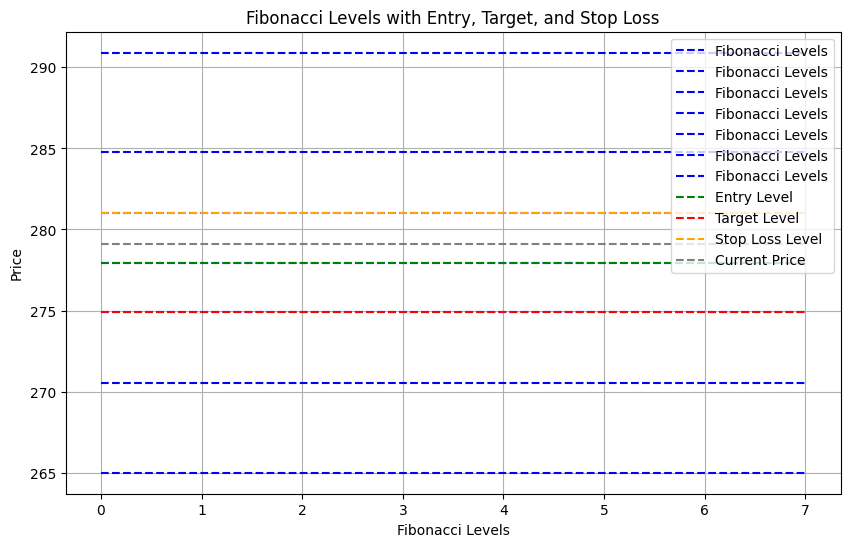

In [123]:
def generate_fibonacci_signals(price, fibonacci_levels):
    entry_level = min(fibonacci_levels, key=lambda x: abs(x - price))
    entry_level_index = fibonacci_levels.index(entry_level)
    
    if entry_level_index < len(fibonacci_levels) - 1:
        target_level = fibonacci_levels[entry_level_index + 1]
    else:
        target_level = None
    
    if entry_level_index > 0:
        stop_loss_level = fibonacci_levels[entry_level_index - 1]
    else:
        stop_loss_level = None
    
    return entry_level, target_level, stop_loss_level


def plot_fibonacci_levels(price, fibonacci_levels, entry_level, target_level, stop_loss_level):
    plt.figure(figsize=(10, 6))
    
    for level in fibonacci_levels:
        plt.hlines(level, 0, len(fibonacci_levels), color='blue', linestyle='--', label='Fibonacci Levels')
    
    # Plot entry, target, and stop loss levels as horizontal lines
    plt.hlines(entry_level, 0, len(fibonacci_levels), color='green', linestyle='--', label='Entry Level')
    plt.hlines(target_level, 0, len(fibonacci_levels), color='red', linestyle='--', label='Target Level')
    plt.hlines(stop_loss_level, 0, len(fibonacci_levels), color='orange', linestyle='--', label='Stop Loss Level')
    
    # Plot current price as a horizontal line
    plt.hlines(price, 0, len(fibonacci_levels), color='gray', linestyle='--', label='Current Price')
    
    plt.xlabel('Fibonacci Levels')
    plt.ylabel('Price')
    plt.title('Fibonacci Levels with Entry, Target, and Stop Loss')
    plt.legend()
    plt.grid(True)
    
    plt.show()

fibonacci_levels = calculate_fibonacci_levels(high, low)
entry_level, target_level, stop_loss_level = generate_fibonacci_signals(price, fibonacci_levels)

plot_fibonacci_levels(price, fibonacci_levels, entry_level, target_level, stop_loss_level)

In [117]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signals_with_prices(stock_data, macd_positions, signals):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot stock prices
    ax.plot(stock_data.index, stock_data['Close'], color='blue', label='Stock Price')

    # Overlay buy and sell signals directly on the stock price line
    buy_positions = [macd_positions[i] for i in range(len(macd_positions)) if signals[i] == 1]
    sell_positions = [macd_positions[i] for i in range(len(macd_positions)) if signals[i] == -1]

    ax.scatter(buy_positions, stock_data.loc[buy_positions]['Close'], c='darkgreen', s=100, label='Buy Signal')
    ax.scatter(sell_positions, stock_data.loc[sell_positions]['Close'], c='darkred', s=100, label='Sell Signal')

    # Light green dots for signals between 0 and 1, and light red dots for signals between -1 and 0
    light_green_positions = [macd_positions[i] for i in range(len(macd_positions)) if 0 < signals[i] < 1]
    light_red_positions = [macd_positions[i] for i in range(len(macd_positions)) if -1 < signals[i] < 0]

    ax.scatter(light_green_positions, stock_data.loc[light_green_positions]['Close'], c='lightgreen', s=50)
    ax.scatter(light_red_positions, stock_data.loc[light_red_positions]['Close'], c='lightcoral', s=50)

    ax.legend()
    ax.set_title('Stock Prices with MACD Signals')
    ax.set_xlabel('Date')
    ax.set_ylabel('Stock Price')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


[*********************100%%**********************]  1 of 1 completed


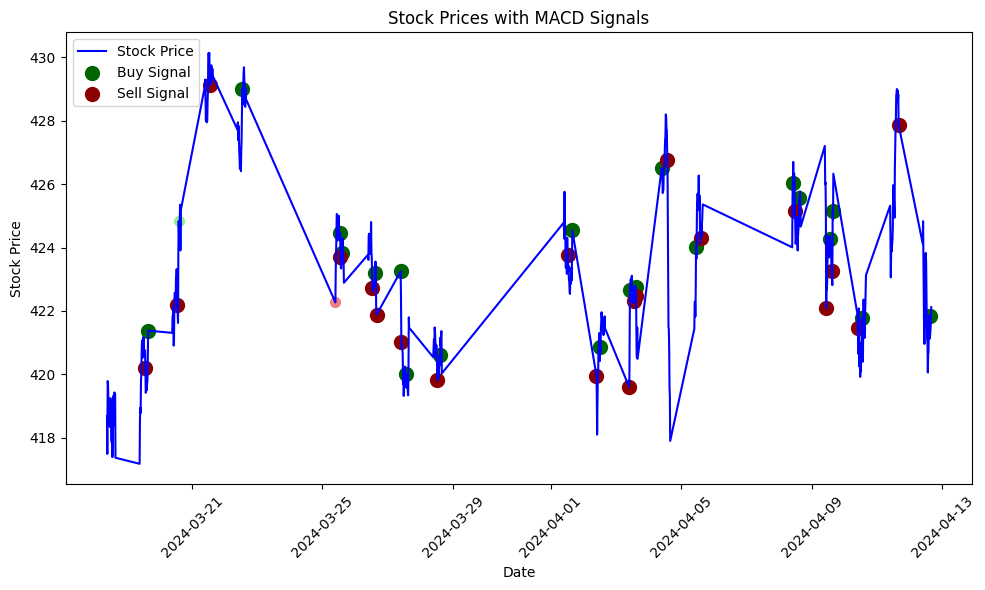

In [4]:
from data import fetch_stock_prices
stock_data = fetch_stock_prices(ticker, start_date, end_date)

if stock_data is not None:
    # Call the function to generate signals
    macd_positions, signals = generate_signals(macd_data, rsi_data)

    # Plot the stock prices with signals
    plot_signals_with_prices(stock_data, macd_positions, signals)

In [5]:
def generate_fibonacci_signals(close_price, fibonacci_levels):
    entry_point = None
    stop_loss = None
    sell_signal = None
    
    for level in fibonacci_levels:
        if close_price <= level:
            entry_point = level
            stop_loss = fibonacci_levels[fibonacci_levels.index(level) - 1]
            break
    
    if entry_point is not None:
        # Calculate 3% above the entry point
        target_price = entry_point * 1.03
        
        # Find the next higher Fibonacci level above the entry point
        next_fib_level = fibonacci_levels[fibonacci_levels.index(entry_point) + 1]
        
        if close_price >= target_price:
            stop_loss = next_fib_level
        elif close_price >= next_fib_level:
            sell_signal = True
    
    return entry_point, stop_loss, sell_signal


In [6]:
def generate_signals(macd_data, rsi_data, close_price, fibonacci_levels):
    macd_signals = []
    macd_positions = []
    rsi_list = []
    rsi_positions = []
    fibonacci_signals = []

    # Generate MACD signals
    for i in range(1, len(macd_data)):
        if macd_data['MACD'][i] > macd_data['MACD Signal'][i] and macd_data['MACD'][i - 1] < macd_data['MACD Signal'][i - 1]:
            macd_signals.append(1)  # Buy signal
            macd_positions.append(macd_data.index[i])
            rsi_list.append(rsi_data['RSI'][i])
            rsi_positions.append(rsi_data.index[i])
        elif macd_data['MACD'][i] < macd_data['MACD Signal'][i] and macd_data['MACD'][i - 1] > macd_data['MACD Signal'][i - 1]:
            macd_signals.append(-1)  # Sell signal
            macd_positions.append(macd_data.index[i])
            rsi_list.append(rsi_data['RSI'][i])
            rsi_positions.append(rsi_data.index[i])
        else:
            macd_signals.append(0)  # No signal
            rsi_list.append(0)  # No signal

    cleaned_macd = [x for x in macd_signals if x != 0.0]
    cleaned_rsi = [x for x in rsi_list if x != 0.0]

    # Combine MACD and RSI signals
    signals = []
    for macd_signal, rsi in zip(cleaned_macd, cleaned_rsi):
        if macd_signal == 1:
            if rsi < 30:
                signals.append(1)
            elif rsi > 70:
                signals.append(0.5)
            else:
                signals.append(1)
        elif macd_signal == -1:
            if rsi < 30:
                signals.append(-0.5)
            elif rsi > 70:
                signals.append(-1)
            else:
                signals.append(-1)
        else:
            signals.append(0)

    # Generate Fibonacci signals
    for level in fibonacci_levels:
        if close_price <= level:
            entry_point = level
            stop_loss = fibonacci_levels[fibonacci_levels.index(level) - 1]
            break

    if entry_point is not None:
        target_price = entry_point * 1.03
        next_fib_level = fibonacci_levels[fibonacci_levels.index(entry_point) + 1]

        if close_price >= target_price:
            stop_loss = next_fib_level
        elif close_price >= next_fib_level:
            sell_signal = True

    fibonacci_signals.append((entry_point, stop_loss, sell_signal))

    return macd_positions, signals, fibonacci_signals

In [7]:
def plot_signals_with_prices(stock_data, macd_positions, macd_signals, fibonacci_signals):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot stock prices
    ax.plot(stock_data.index, stock_data['Close'], color='blue', label='Stock Price')

    # Overlay MACD buy and sell signals directly on the stock price line
    buy_positions = [macd_positions[i] for i in range(len(macd_positions)) if macd_signals[i] == 1]
    sell_positions = [macd_positions[i] for i in range(len(macd_positions)) if macd_signals[i] == -1]
    ax.scatter(buy_positions, stock_data.loc[buy_positions]['Close'], c='darkgreen', s=100, label='Buy Signal')
    ax.scatter(sell_positions, stock_data.loc[sell_positions]['Close'], c='darkred', s=100, label='Sell Signal')

    # Overlay Fibonacci signals directly on the stock price line
    for level in fibonacci_levels:
        entry_point = None  # Initialize variables for this level
        stop_loss = None
        sell_signal = None
    
        for price in close_price:  # Iterate over each element of close_price
            if price <= level:
                entry_point = level
                stop_loss = fibonacci_levels[fibonacci_levels.index(level) - 1]
                break
    
        if entry_point is not None:
            target_price = entry_point * 1.03
            next_fib_level = fibonacci_levels[fibonacci_levels.index(entry_point) + 1]
        
            if price >= target_price:
                stop_loss = next_fib_level
            elif price >= next_fib_level:
                sell_signal = True
    
        fibonacci_signals.append((entry_point, stop_loss, sell_signal))
        
    ax.legend()
    ax.set_title('Stock Prices with MACD and Fibonacci Signals')
    ax.set_xlabel('Date')
    ax.set_ylabel('Stock Price')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
ticker = 'MSFT'
start_date = (datetime.today() - timedelta(days=30)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

from window import calculate_fibonacci_levels
# Fetch stock prices
stock_data = fetch_stock_prices(ticker, start_date, end_date)

if stock_data is not None:
    # Generate MACD and RSI data (you need to replace these with your actual data)
    macd_data = fetch_macd(ticker, start_date, end_date)
    rsi_data = rsi_data = fetch_rsi(ticker, start_date, end_date)

    # Generate Fibonacci levels (you need to replace this with your actual data)
    high = np.max(stock_data['High'])
    low = np.min(stock_data['Low'])
    fibonacci_levels = calculate_fibonacci_levels(high, low)

    # Call the combined function to generate all signals
    macd_positions, macd_signals, fibonacci_signals = generate_signals(macd_data, rsi_data, stock_data['Close'], fibonacci_levels)

    # Plot the stock prices with signals
    plot_signals_with_prices(stock_data, macd_positions, macd_signals, fibonacci_signals)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().